# Bike Pattern 2

We used a little bit of machine learning on [Divvy Data](https://www.divvybikes.com/system-data) to dig into a better division of Chicago. We try to identify patterns among bike stations.

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline

## The data

[Divvy Data](https://www.divvybikes.com/system-data) publishes a sample of the data. 

In [ ]:
from pyensae.datasource import download_data
file = download_data("Divvy_Trips_2016_Q3Q4.zip", url="https://s3.amazonaws.com/divvy-data/tripdata/")

We know the stations.

In [ ]:
import pandas
stations = pandas.read_csv("Divvy_Stations_2016_Q3.csv")
bikes = pandas.concat([pandas.read_csv("Divvy_Trips_2016_Q3.csv"),
                       pandas.read_csv("Divvy_Trips_2016_Q4.csv")])

In [ ]:
bikes.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,12150160,9/30/2016 23:59:58,10/1/2016 00:04:03,4959,245,69,Damen Ave & Pierce Ave,17,Wood St & Division St,Subscriber,Male,1988.0
1,12150159,9/30/2016 23:59:58,10/1/2016 00:04:09,2589,251,383,Ashland Ave & Harrison St,320,Loomis St & Lexington St,Subscriber,Female,1990.0
2,12150158,9/30/2016 23:59:51,10/1/2016 00:24:51,3656,1500,302,Sheffield Ave & Wrightwood Ave,334,Lake Shore Dr & Belmont Ave,Customer,NaN,NaN
3,12150157,9/30/2016 23:59:51,10/1/2016 00:03:56,3570,245,475,Washtenaw Ave & Lawrence Ave,471,Francisco Ave & Foster Ave,Subscriber,Female,1988.0
4,12150156,9/30/2016 23:59:32,10/1/2016 00:26:50,3158,1638,302,Sheffield Ave & Wrightwood Ave,492,Leavitt St & Addison St,Customer,NaN,NaN


In [ ]:
from datetime import datetime, time
df = bikes
df["dtstart"] = pandas.to_datetime(df.starttime, infer_datetime_format=True)
df["dtstop"] = pandas.to_datetime(df.stoptime, infer_datetime_format=True)

df["stopday"] = df.dtstop.apply(lambda r: datetime(r.year, r.month, r.day))
df["stoptime"] = df.dtstop.apply(lambda r: time(r.hour, r.minute, 0))
df["stoptime10"] = df.dtstop.apply(lambda r: time(r.hour, (r.minute // 10)*10, 0))  # every 10 minutes

df["startday"] = df.dtstart.apply(lambda r: datetime(r.year, r.month, r.day))
df["starttime"] = df.dtstart.apply(lambda r: time(r.hour, r.minute, 0))
df["starttime10"] = df.dtstart.apply(lambda r: time(r.hour, (r.minute // 10)*10, 0))  # every 10 minutes

In [ ]:
df['stopweekday'] = df['dtstop'].dt.dayofweek
df['startweekday'] = df['dtstart'].dt.dayofweek

## Normalize, aggregating and merging per start and stop time

In [ ]:
key = ["to_station_id", "to_station_name", "stopweekday", "stoptime10"]
keep = key + ["trip_id"]

stopaggtime = df[keep].groupby(key, as_index=False).count()
stopaggtime.columns = key + ["nb_trips"]

stopaggday = df[keep[:-2] + ["trip_id"]].groupby(key[:-1], as_index=False).count()
stopaggday.columns = key[:-1] + ["nb_trips"]

stopaggday = df[keep[:-2] + ["trip_id"]].groupby(key[:-1], as_index=False).count()
stopaggday.columns = key[:-1] + ["nb_trips"]

stopmerge = stopaggtime.merge(stopaggday, on=key[:-1], suffixes=("", "day"))
stopmerge["stopdist"] = stopmerge["nb_trips"] / stopmerge["nb_tripsday"]
stopmerge.head()

,to_station_id,to_station_name,stopweekday,stoptime10,nb_trips,nb_tripsday,stopdist
0,2,Michigan Ave & Balbo Ave,0,00:10:00,2,913,0.002191
1,2,Michigan Ave & Balbo Ave,0,00:20:00,2,913,0.002191
2,2,Michigan Ave & Balbo Ave,0,00:30:00,2,913,0.002191
3,2,Michigan Ave & Balbo Ave,0,01:00:00,3,913,0.003286
4,2,Michigan Ave & Balbo Ave,0,01:10:00,2,913,0.002191


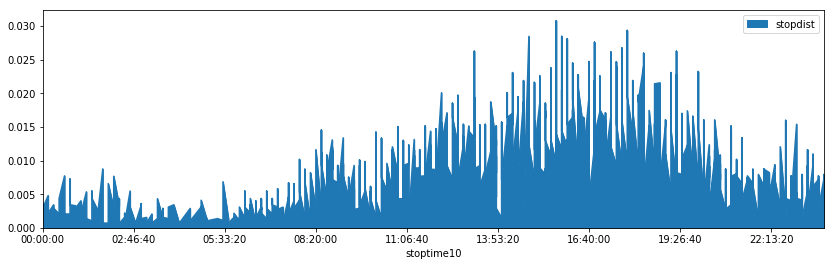

In [ ]:
stopmerge[stopmerge["to_station_id"] == 2] \
       .plot(x="stoptime10", y="stopdist", figsize=(14,4), kind="area")

In [ ]:
key = ["from_station_id", "from_station_name", "startweekday", "starttime10"]
keep = key + ["trip_id"]

startaggtime = df[keep].groupby(key, as_index=False).count()
startaggtime.columns = key + ["nb_trips"]

startaggday = df[keep[:-2] + ["trip_id"]].groupby(key[:-1], as_index=False).count()
startaggday.columns = key[:-1] + ["nb_trips"]

startaggday = df[keep[:-2] + ["trip_id"]].groupby(key[:-1], as_index=False).count()
startaggday.columns = key[:-1] + ["nb_trips"]

startmerge = startaggtime.merge(startaggday, on=key[:-1], suffixes=("", "day"))
startmerge["startdist"] = startmerge["nb_trips"] / startmerge["nb_tripsday"]
startmerge.head()

,from_station_id,from_station_name,startweekday,starttime10,nb_trips,nb_tripsday,startdist
0,2,Michigan Ave & Balbo Ave,0,00:00:00,4,1065,0.003756
1,2,Michigan Ave & Balbo Ave,0,00:10:00,1,1065,0.000939
2,2,Michigan Ave & Balbo Ave,0,00:20:00,3,1065,0.002817
3,2,Michigan Ave & Balbo Ave,0,00:50:00,4,1065,0.003756
4,2,Michigan Ave & Balbo Ave,0,01:10:00,3,1065,0.002817


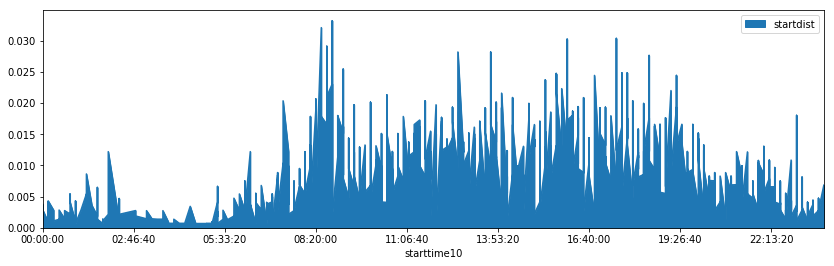

In [ ]:
startmerge[startmerge["from_station_id"] == 2] \
         .plot(x="starttime10",  y="startdist", figsize=(14,4), kind="area")

In [ ]:
everything = stopmerge.merge(startmerge,
                             left_on=["to_station_id", "to_station_name", "stopweekday", "stoptime10"],
                             right_on=["from_station_id", "from_station_name","startweekday", "starttime10"],
                             suffixes=("stop", "start"),
                             how="outer")
everything.head()

,to_station_id,to_station_name,stopweekday,stoptime10,nb_tripsstop,nb_tripsdaystop,stopdist,from_station_id,from_station_name,startweekday,starttime10,nb_tripsstart,nb_tripsdaystart,startdist
0,2.0,Michigan Ave & Balbo Ave,0.0,00:10:00,2.0,913.0,0.002191,2.0,Michigan Ave & Balbo Ave,0.0,00:10:00,1.0,1065.0,0.000939
1,2.0,Michigan Ave & Balbo Ave,0.0,00:20:00,2.0,913.0,0.002191,2.0,Michigan Ave & Balbo Ave,0.0,00:20:00,3.0,1065.0,0.002817
2,2.0,Michigan Ave & Balbo Ave,0.0,00:30:00,2.0,913.0,0.002191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,Michigan Ave & Balbo Ave,0.0,01:00:00,3.0,913.0,0.003286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,Michigan Ave & Balbo Ave,0.0,01:10:00,2.0,913.0,0.002191,2.0,Michigan Ave & Balbo Ave,0.0,01:10:00,3.0,1065.0,0.002817


In [ ]:
import numpy
from datetime import datetime

def bestof(x, y):
    if isinstance(x, (datetime, time, str)):
        return x
    try:
        if x is None or isinstance(y, (datetime, time, str)) or numpy.isnan(x):
            return y
        else:
            return x
    except:
        print(type(x), type(y))
        print(x, y)
        raise
        
bestof(datetime(2017,2,2), numpy.nan), bestof(numpy.nan, datetime(2017,2,2))

(datetime.datetime(2017, 2, 2, 0, 0), datetime.datetime(2017, 2, 2, 0, 0))

In [ ]:
every = everything.copy()
every["station_name"] = every.apply(lambda row: bestof(row["to_station_name"], row["from_station_name"]), axis=1)
every["station_id"] = every.apply(lambda row: bestof(row["to_station_id"], row["from_station_id"]), axis=1)
every["time10"] = every.apply(lambda row: bestof(row["stoptime10"], row["starttime10"]), axis=1)
every["weekday"] = every.apply(lambda row: bestof(row["stopweekday"], row["startweekday"]), axis=1)
every = every.drop(["stoptime10", "starttime10", "stopweekday", "startweekday",
                    "to_station_id", "from_station_id",
                    "to_station_name", "from_station_name"], axis=1)
every.head()

,nb_tripsstop,nb_tripsdaystop,stopdist,nb_tripsstart,nb_tripsdaystart,startdist,station_name,station_id,time10,weekday
0,2.0,913.0,0.002191,1.0,1065.0,0.000939,Michigan Ave & Balbo Ave,2.0,00:10:00,0.0
1,2.0,913.0,0.002191,3.0,1065.0,0.002817,Michigan Ave & Balbo Ave,2.0,00:20:00,0.0
2,2.0,913.0,0.002191,NaN,NaN,NaN,Michigan Ave & Balbo Ave,2.0,00:30:00,0.0
3,3.0,913.0,0.003286,NaN,NaN,NaN,Michigan Ave & Balbo Ave,2.0,01:00:00,0.0
4,2.0,913.0,0.002191,3.0,1065.0,0.002817,Michigan Ave & Balbo Ave,2.0,01:10:00,0.0


In [ ]:
every.shape, stopmerge.shape, startmerge.shape

We need vectors of equal size which means filling NaN values with 0 and adding times when not present.

In [ ]:
every.columns

Index(['nb_tripsstop', 'nb_tripsdaystop', 'stopdist', 'nb_tripsstart',
       'nb_tripsdaystart', 'startdist', 'station_name', 'station_id', 'time10',
       'weekday'],
      dtype='object')

In [ ]:
keys = ['station_name', 'station_id', 'weekday', 'time10']
for c in every.columns:
    if c not in keys:
        every[c].fillna(0)

In [ ]:
from ensae_projects.datainc.data_bikes import add_missing_time
full = df = add_missing_time(every, delay=10,  column="time10", 
                             values=[c for c in every.columns if c not in keys])
full = full[['station_name', 'station_id', 'time10', 'weekday', 
             'stopdist', 'startdist',
             'nb_tripsstop', 'nb_tripsdaystop', 'nb_tripsstart',
       'nb_tripsdaystart']].sort_values(keys)
full.head()

,station_name,station_id,time10,weekday,stopdist,startdist,nb_tripsstop,nb_tripsdaystop,nb_tripsstart,nb_tripsdaystart
357809,2112 W Peterson Ave,456.0,00:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
357810,2112 W Peterson Ave,456.0,00:10:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
357811,2112 W Peterson Ave,456.0,00:20:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
341443,2112 W Peterson Ave,456.0,00:30:00,0.0,0.0,0.021277,0.0,0.0,1.0,47.0
357812,2112 W Peterson Ave,456.0,00:40:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Clustering (stop and start)

We cluster these distribution to find some patterns. But we need vectors of equal size which should be equal to 24*6.

This is much better.

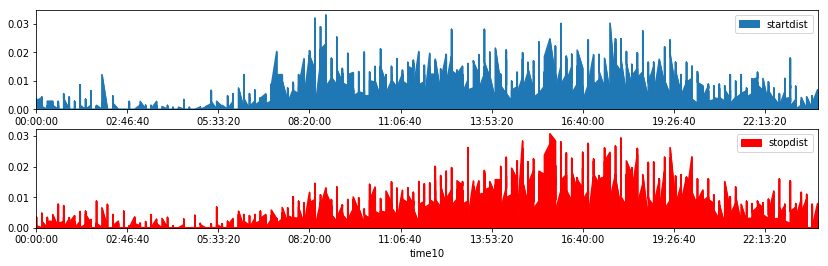

In [ ]:
df = full
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(14,6))
df[df["station_id"] == 2].plot(x="time10", y="startdist", figsize=(14,4), kind="area", ax=ax[0])
df[df["station_id"] == 2].plot(x="time10", y="stopdist", figsize=(14,4), 
                               kind="area", ax=ax[1], color="r")

Let's build the features.

In [ ]:
features = df.pivot_table(index=["station_id", "station_name", "weekday"],
                          columns="time10", values=["startdist", "stopdist"]).reset_index()

features.head()

station_id              station_name weekday startdist            \
time10                                               00:00:00  00:10:00   
0             2.0  Michigan Ave & Balbo Ave     0.0  0.003756  0.000939   
1             2.0  Michigan Ave & Balbo Ave     1.0  0.000000  0.000000   
2             2.0  Michigan Ave & Balbo Ave     2.0  0.001357  0.002714   
3             2.0  Michigan Ave & Balbo Ave     3.0  0.000000  0.004144   
4             2.0  Michigan Ave & Balbo Ave     4.0  0.000000  0.000000   

                                                            ...     stopdist  \
time10  00:20:00  00:30:00  00:40:00  00:50:00  01:00:00    ...     22:20:00   
0       0.002817  0.000000  0.000000  0.003756  0.000000    ...     0.004381   
1       0.001106  0.001106  0.001106  0.002212  0.000000    ...     0.009371   
2       0.000000  0.001357  0.000000  0.005427  0.000000    ...     0.002907   
3       0.000000  0.000000  0.002762  0.004144  0.000000    ...     0.009274   
4       0.000000  0.002846  0.000000  0.000000  0.000949    ...     0.008214   

                                                                              \
time10  22:30:00  22:40:00  22:50:00  23:00:00  23:10:00  23:20:00  23:30:00   
0       0.002191  0.004381  0.002191  0.004381  0.004381  0.005476  0.002191   
1       0.012048  0.006693  0.004016  0.005355  0.006693  0.002677  0.000000   
2       0.002907  0.015988  0.005814  0.001453  0.001453  0.011628  0.000000   
3       0.003091  0.003091  0.007728  0.001546  0.003091  0.009274  0.001546   
4       0.001027  0.006160  0.004107  0.015400  0.006160  0.002053  0.006160   

                            
time10  23:40:00  23:50:00  
0       0.000000  0.005476  
1       0.000000  0.000000  
2       0.000000  0.007267  
3       0.007728  0.001546  
4       0.007187  0.000000  

[5 rows x 291 columns]

In [ ]:
names = features.columns[3:]
len(names)

288

In [ ]:
from sklearn.cluster import KMeans
clus = KMeans(8)
clus.fit(features[names])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
pred = clus.predict(features[names])
set(pred)

{0, 1, 2, 3, 4, 5, 6, 7}

In [ ]:
features["cluster"] = pred

Let's see what it means accross day. We need to look whether or not a cluster is related to day of the working week or the week end.

In [ ]:
features[["cluster", "weekday", "station_id"]].groupby(["cluster", "weekday"]).count()

c:\python35_x64\lib\site-packages\pandas\core\base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


station_id
time10                    
cluster weekday           
0       0.0            120
        1.0            122
        2.0            129
        3.0            125
        4.0            136
        5.0              7
        6.0             13
1       1.0              1
        5.0              2
2       5.0              1
        6.0              1
3       0.0            187
        1.0            206
        2.0            205
        3.0            187
        4.0            163
        5.0             46
        6.0             40
4       0.0              3
        1.0              2
        2.0              6
        3.0              2
        4.0              3
        6.0              3
5       0.0            173
        1.0            181
        2.0            184
        3.0            182
        4.0            179
        5.0              9
        6.0              4
6       0.0             93
        1.0             66
        2.0             56
        3.0             80
        4.0             98
        5.0            512
        6.0            518
7       3.0              1
        4.0              1
        5.0              3
        6.0              1

c:\python35_x64\lib\site-packages\pandas\core\base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


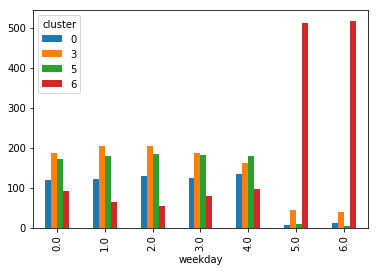

In [ ]:
nb = features[["cluster", "weekday", "station_id"]].groupby(["cluster", "weekday"]).count()
nb = nb.reset_index()
nb[nb.cluster.isin([0, 3, 5, 6])].pivot("weekday","cluster", "station_id").plot(kind="bar")

Let's draw the clusters.

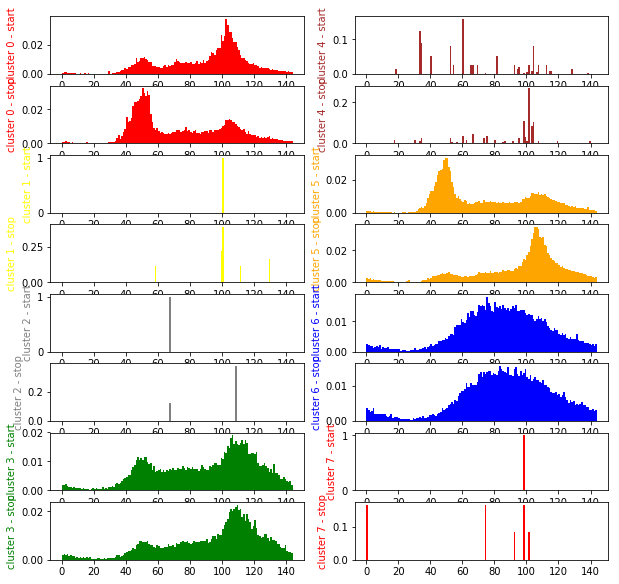

In [ ]:
centers = clus.cluster_centers_.T
import matplotlib.pyplot as plt
fig, ax = plt.subplots(centers.shape[1], 2, figsize=(10,10))
nbf = centers.shape[0] // 2
x = list(range(0,nbf))
col = 0
dec = 0
colors = ["red", "yellow", "gray", "green", "brown", "orange", "blue"]
for i in range(centers.shape[1]):
    if 2*i == centers.shape[1]:
        col += 1
        dec += centers.shape[1]    
    color = colors[i%len(colors)]
    ax[2*i-dec, col].bar (x, centers[:nbf,i], width=1.0, color=color)
    ax[2*i-dec, col].set_ylabel("cluster %d - start" % i, color=color)
    ax[2*i+1-dec, col].bar (x, centers[nbf:,i], width=1.0, color=color)
    ax[2*i+1-dec, col].set_ylabel("cluster %d - stop" % i, color=color)

Four patterns emerge. Small clusters are annoying but let's show them on a map. The widest one is the one for the week-end.

## Graph

We first need to get 7 clusters for each stations, one per day.

In [ ]:
piv = features.pivot_table(index=["station_id","station_name"], 
                           columns="weekday", values="cluster")
piv.head()

c:\python35_x64\lib\site-packages\pandas\core\base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


time10                                                                
weekday                              0.0  1.0  2.0  3.0  4.0  5.0  6.0
station_id station_name                                               
2.0        Michigan Ave & Balbo Ave  6.0  3.0  3.0  3.0  6.0  6.0  6.0
3.0        Shedd Aquarium            6.0  6.0  6.0  6.0  6.0  6.0  6.0
4.0        Burnham Harbor            6.0  3.0  3.0  6.0  6.0  6.0  6.0
5.0        State St & Harrison St    3.0  3.0  3.0  3.0  3.0  6.0  6.0
6.0        Dusable Harbor            6.0  6.0  3.0  6.0  6.0  6.0  6.0

In [ ]:
piv["distincts"] = piv.apply(lambda row: len(set(row[i] for i in range(0,7))), axis=1)

Let's see which station is classified in more than 4 clusters. NaN means no bikes stopped at this stations. They are mostly unused stations.

In [ ]:
piv[piv.distincts >= 4]

time10                                                                     \
weekday                                 0.0  1.0  2.0  3.0  4.0  5.0  6.0   
station_id station_name                                                     
384.0      Halsted St & 51st St         6.0  4.0  6.0  3.0  4.0  3.0  0.0   
391.0      Halsted St & 69th St         3.0  5.0  3.0  3.0  6.0  6.0  0.0   
393.0      Calumet Ave & 71st St        0.0  6.0  6.0  6.0  5.0  6.0  3.0   
409.0      Shields Ave & 43rd St        6.0  6.0  4.0  6.0  0.0  5.0  6.0   
415.0      Calumet Ave & 51st St        6.0  5.0  3.0  6.0  6.0  6.0  0.0   
440.0      Lawndale Ave & 23rd St       3.0  3.0  6.0  5.0  0.0  6.0  6.0   
448.0      Warren Park East             3.0  3.0  5.0  3.0  0.0  3.0  6.0   
477.0      Manor Ave & Leland Ave       0.0  5.0  3.0  0.0  0.0  3.0  6.0   
529.0      Cicero Ave & Lake St         5.0  3.0  3.0  0.0  6.0  6.0  0.0   
532.0      Austin Blvd & Lake St        5.0  3.0  3.0  3.0  0.0  6.0  6.0   
539.0      Cicero Ave & Quincy St       5.0  3.0  5.0  6.0  4.0  6.0  0.0   
549.0      Marshfield Ave & 44th St     0.0  6.0  NaN  6.0  3.0  6.0  0.0   
551.0      Hoyne Ave & 47th St          6.0  3.0  4.0  0.0  6.0  3.0  6.0   
555.0      Ashland Ave & 50th St        6.0  6.0  6.0  0.0  3.0  6.0  5.0   
556.0      Throop St & 52nd St          4.0  5.0  4.0  3.0  4.0  7.0  4.0   
557.0      Damen Ave & Garfield Blvd    NaN  1.0  4.0  NaN  0.0  NaN  NaN   
558.0      Ashland Ave & Garfield Blvd  NaN  6.0  6.0  6.0  6.0  1.0  NaN   
561.0      Damen Ave & 61st St          0.0  5.0  0.0  5.0  NaN  6.0  6.0   
562.0      Racine Ave & 61st St         NaN  NaN  NaN  NaN  5.0  NaN  NaN   
564.0      Racine Ave & 65th St         6.0  6.0  NaN  NaN  5.0  6.0  5.0   
565.0      Ashland Ave & 66th St        6.0  6.0  NaN  7.0  6.0  NaN  6.0   
566.0      Ashland Ave & 69th St        6.0  0.0  5.0  3.0  6.0  6.0  2.0   
567.0      May St & 69th St             0.0  0.0  0.0  0.0  6.0  7.0  NaN   
568.0      Normal Ave & 72nd St         4.0  3.0  3.0  NaN  3.0  6.0  6.0   
569.0      Woodlawn Ave & 75th St       6.0  NaN  3.0  6.0  6.0  NaN  6.0   
571.0      Vernon Ave & 75th St         3.0  4.0  3.0  6.0  7.0  6.0  6.0   
575.0      Cottage Grove Ave & 78th St  0.0  3.0  3.0  6.0  5.0  6.0  3.0   
576.0      Greenwood Ave & 79th St      5.0  3.0  3.0  NaN  0.0  2.0  3.0   
580.0      Exchange Ave & 79th St       6.0  NaN  3.0  3.0  5.0  6.0  3.0   
581.0      Commercial Ave & 83rd St     6.0  NaN  3.0  NaN  NaN  6.0  3.0   
582.0      Phillips Ave & 82nd St       NaN  NaN  6.0  3.0  NaN  6.0  4.0   
584.0      Ellis Ave & 83rd St          NaN  6.0  6.0  6.0  0.0  3.0  3.0   
587.0      Wabash Ave & 83rd St         NaN  NaN  6.0  NaN  6.0  0.0  3.0   
588.0      South Chicago Ave & 83rd St  NaN  3.0  3.0  3.0  6.0  1.0  5.0   
593.0      Halsted St & 59th St         NaN  5.0  6.0  6.0  NaN  6.0  6.0   
595.0      Wabash Ave & 87th St         0.0  6.0  3.0  4.0  6.0  5.0  3.0   

time10                                 distincts  
weekday                                           
station_id station_name                           
384.0      Halsted St & 51st St                4  
391.0      Halsted St & 69th St                4  
393.0      Calumet Ave & 71st St               4  
409.0      Shields Ave & 43rd St               4  
415.0      Calumet Ave & 51st St               4  
440.0      Lawndale Ave & 23rd St              4  
448.0      Warren Park East                    4  
477.0      Manor Ave & Leland Ave              4  
529.0      Cicero Ave & Lake St                4  
532.0      Austin Blvd & Lake St               4  
539.0      Cicero Ave & Quincy St              5  
549.0      Marshfield Ave & 44th St            4  
551.0      Hoyne Ave & 47th St                 4  
555.0      Ashland Ave & 50th St               4  
556.0      Throop St & 52nd St                 4  
557.0      Damen Ave & Garfield Blvd           7  
558.0      Ashland Ave & Ga

In [ ]:
pivn = piv.reset_index()
pivn.columns = [' '.join(str(_).replace(".0", "") for _ in col).strip() for col in pivn.columns.values]
pivn.head()

,station_id,station_name,0,1,2,3,4,5,6,distincts
0,2.0,Michigan Ave & Balbo Ave,6.0,3.0,3.0,3.0,6.0,6.0,6.0,2
1,3.0,Shedd Aquarium,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1
2,4.0,Burnham Harbor,6.0,3.0,3.0,6.0,6.0,6.0,6.0,2
3,5.0,State St & Harrison St,3.0,3.0,3.0,3.0,3.0,6.0,6.0,2
4,6.0,Dusable Harbor,6.0,6.0,3.0,6.0,6.0,6.0,6.0,2


Let's draw a map on a week day.

In [ ]:
data = stations.merge(pivn, left_on=["id", "name"],
                      right_on=["station_id", "station_name"], suffixes=('_s', '_c'))
data.sort_values("id").head()

,id,name,latitude,longitude,dpcapacity,online_date,station_id,station_name,0,1,2,3,4,5,6,distincts
357,2,Michigan Ave & Balbo Ave,41.872638,-87.623979,35,5/8/2015,2.0,Michigan Ave & Balbo Ave,6.0,3.0,3.0,3.0,6.0,6.0,6.0,2
456,3,Shedd Aquarium,41.867226,-87.615355,31,4/24/2015,3.0,Shedd Aquarium,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1
53,4,Burnham Harbor,41.856268,-87.613348,23,5/16/2015,4.0,Burnham Harbor,6.0,3.0,3.0,6.0,6.0,6.0,6.0,2
497,5,State St & Harrison St,41.874053,-87.627716,23,6/18/2013,5.0,State St & Harrison St,3.0,3.0,3.0,3.0,3.0,6.0,6.0,2
188,6,Dusable Harbor,41.885042,-87.612795,31,4/24/2015,6.0,Dusable Harbor,6.0,6.0,3.0,6.0,6.0,6.0,6.0,2


In [ ]:
from ensae_projects.datainc.data_bikes import folium_html_stations_map

colors = ["red", "yellow", "gray", "green", "brown", "orange", "blue", "black"]
for i, c in enumerate(colors):
    print("Cluster {0} is {1}".format(i, c))
xy = []
for els in data.apply(lambda row: (row["latitude"], row["longitude"], row["1"], row["name"]), axis=1):
    try:
        cl = int(els[2])
    except:
        # NaN
        continue
    name = "%s c%d" % (els[3], cl)
    color = colors[cl]
    xy.append( ( (els[0], els[1]), (name, color)))
folium_html_stations_map(xy, width="80%")

Cluster 0 is red
Cluster 1 is yellow
Cluster 2 is gray
Cluster 3 is green
Cluster 4 is brown
Cluster 5 is orange
Cluster 6 is blue
Cluster 7 is black


<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x20c06e33128>

Look at the colors close the parks. We notice than people got to the park after work. Let's see during the week-end.

In [ ]:
xy = []
for els in data.apply(lambda row: (row["latitude"], row["longitude"], row["5"], row["name"]), axis=1):
    try:
        cl = int(els[2])
    except:
        # NaN
        continue
    name = "%s c%d" % (els[3], cl)
    color = colors[cl]
    xy.append( ( (els[0], els[1]), (name, color)))
folium_html_stations_map(xy, width="80%")

<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x20c00990e80>